## **Twitter Watch**

Have you ever wished you could have a summary of particular accounts without reading all of their tweets? Were you ever curious who are the top fans of those accounts?
Or simpler, did you ever wish you could search through an account's tweets in a csv file rather than twitter? Here, we can do all of these tasks using several lines of coding.  

We first want to extract tweets from various accounts, then categorize them using sentiment analysis to positive, neutral, or negative. We then will get the latest 5000 replies and do a sentiment analysis on those too. Next, we identify the top 5 active followers of these accounts. And finally, we summarize the accounts in 1 and 2 paragraphs. This way, you will know what each accout has been mainly focused on in a particular period of time. 

Ok, let's get started.

Here are the accounts for which we are scrapping the tweets since Feb 1st:

1. Elon Musk (@elonmusk)
2. Barack Obama (@BarackObama)
3. Cathie Wood (@cathiedwood)

We will do all the steps separately for each one of these accounts.

## 1. Elon Musk

### 1.1. Scraping tweets


In [1]:
! pip install snscrape
import pandas as pd
import snscrape.modules.twitter as sntwitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
query_elon = '(from:elonmusk) until:2023-03-11 since:2023-02-01'
limit = 2000
tweets_elon = []
for tweet in sntwitter.TwitterSearchScraper(query_elon).get_items():
  #print(vars(tweet))
  #break
  if len(tweets_elon)==limit:
    break
  else:
    tweets_elon.append([tweet.date, tweet.user.username, tweet.content])
  
  df_elon = pd.DataFrame(tweets_elon,columns = ['date','username','tweet'])



<ipython-input-2-d05b2c3808d3>:10: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_elon.append([tweet.date, tweet.user.username, tweet.content])


In [3]:
print(df_elon)

                         date  username  \
0   2023-03-10 21:11:39+00:00  elonmusk   
1   2023-03-10 20:04:01+00:00  elonmusk   
2   2023-03-10 17:03:53+00:00  elonmusk   
3   2023-03-10 08:57:00+00:00  elonmusk   
4   2023-03-10 08:55:56+00:00  elonmusk   
..                        ...       ...   
946 2023-02-01 03:56:47+00:00  elonmusk   
947 2023-02-01 03:52:10+00:00  elonmusk   
948 2023-02-01 03:42:03+00:00  elonmusk   
949 2023-02-01 03:38:03+00:00  elonmusk   
950 2023-02-01 03:32:38+00:00  elonmusk   

                                                 tweet  
0                                   @TheRabbitHole84 !  
1                 @ShellenbergerMD Very entertaining 🤣  
2                       @BillyM2k He studied the blade  
3                                  @JonathanTurley Wow  
4                                        @allgarbled 😂  
..                                                 ...  
946  @MrAndyNgo @pwsyme Business Insider is not a r...  
947  @RepDanBishop @Shellen

### 1.2. Sentiment Analysis

Alright, we got the tweets. Now, lets do sentiment analysis using zero-shot classification in three categories: 

1. Positive
2. Neutral
3. Negative

We first look at Elon's tweets and then the replies. 
Note: speciall thanks to the sweet Hugging Face APIs!
#### 1.2.1. Elon's Tweets

In [5]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.2 MB/s eta 0:00:00


In [4]:
from transformers import pipeline
import numpy as np
classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
Tweetlist = list(df_elon['tweet'])

candiadte_labels = ['positive','neutral','negative']
output_elon = classifier(Tweetlist, candiadte_labels)


In [142]:
len(output_elon)

951

In [141]:
#Just an example of all the 951 tweets:
output_elon[0:10]

[{'sequence': '@TheRabbitHole84 !',
  'labels': ['positive', 'negative', 'neutral'],
  'scores': [0.7650752067565918, 0.18303188681602478, 0.05189292132854462]},
 {'sequence': '@ShellenbergerMD Very entertaining 🤣',
  'labels': ['positive', 'negative', 'neutral'],
  'scores': [0.7543359398841858, 0.1397538036108017, 0.1059102714061737]},
 {'sequence': '@BillyM2k He studied the blade',
  'labels': ['positive', 'neutral', 'negative'],
  'scores': [0.4219987094402313, 0.3409610092639923, 0.23704032599925995]},
 {'sequence': '@JonathanTurley Wow',
  'labels': ['positive', 'negative', 'neutral'],
  'scores': [0.7934388518333435, 0.11084993928670883, 0.09571126848459244]},
 {'sequence': '@allgarbled 😂',
  'labels': ['negative', 'neutral', 'positive'],
  'scores': [0.9489966630935669, 0.0373486690223217, 0.013654639013111591]},
 {'sequence': '@Teslaconomics https://t.co/gBOq3Yp1yH',
  'labels': ['positive', 'neutral', 'negative'],
  'scores': [0.5711160898208618, 0.22246728837490082, 0.206416

Perfect! Now we have scores of each category for each tweet. If we average these scores per categiry across tweets, we have gained a measure to analyze the account itself within that period. Let's see: 

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

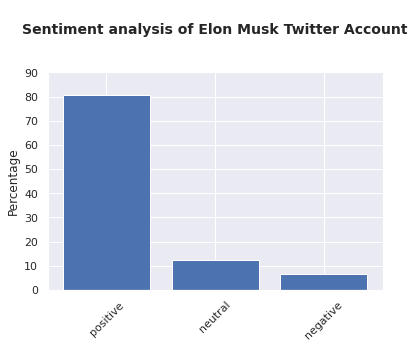

In [36]:

avg_score_elon = [0,0,0]
for i in range(0,len(output_elon)):
  avg_score_elon = np.array(output_elon[i]['scores'])+avg_score_elon


plt.bar(x=candiadte_labels, height=100* avg_score_elon/len(output_elon))
plt.yticks(list(np.arange(0,100,10)))
plt.xticks(rotation = 45)
plt.title("\nSentiment analysis of Elon Musk Twitter Account\n\n", fontsize = 14, fontweight = 'bold')
plt.ylabel("Percentage")
plt.show()

Quite positive! Let's now look at the replies. I limitated them to 5000 tweets due to computational load but we can simply remove the limitation.

#### 1.2.2. Tweet Replies

In [86]:
import pandas as pd
query = '(to:elonmusk) until:2023-03-10- since:2023-02-01'
limit = 5000
tweets = []
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  #print(vars(tweet))
  #break
  if len(tweets)==limit:
    break
  else:
    tweets.append([tweet.date, tweet.user.username, tweet.content])
  
  df = pd.DataFrame(tweets,columns = ['date','username','tweet'])

<ipython-input-86-1ab127b8f4e0>:11: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets.append([tweet.date, tweet.user.username, tweet.content])


In [87]:
df

,date,username,tweet
0,2023-03-09 23:59:59+00:00,NMinakhi,@elonmusk @KanekoaTheGreat 💯
1,2023-03-09 23:59:58+00:00,adanwachinemelu,@elonmusk @MattWallace888 @iheartmindy @SenSch...
2,2023-03-09 23:59:56+00:00,bsizzlehbg,@elonmusk @MattWallace888 @iheartmindy @SenSch...
3,2023-03-09 23:59:56+00:00,ShaunThom79,@elonmusk @cb_doge Sorry we need a higher stan...
4,2023-03-09 23:59:56+00:00,DecentralizeADA,@elonmusk @CollinRugg The democrats are so fri...
...,...,...,...
4995,2023-03-09 22:56:54+00:00,JasonErhard,@elonmusk @CollinRugg Not cool at all!
4996,2023-03-09 22:56:52+00:00,LisaMarieB2,@elonmusk Beautiful
4997,2023-03-09 22:56:50+00:00,LuckasNFT,@elonmusk and if you find one of these there? ...
4998,2023-03-09 22:56:50+00:00,lopatonok,@elonmusk Wishing a happy burning! From the st...


In [88]:
Tweetlist = list(df['tweet'])

candiadte_labels = ['positive','neutral','negative']
output_toelon = classifier(Tweetlist, candiadte_labels)


Here, we can we how positive or negative the tweet replies are: 

In [143]:
# just some examples of the replies
output_toelon[0:10]

[{'sequence': '@elonmusk @KanekoaTheGreat 💯',
  'labels': ['positive', 'neutral', 'negative'],
  'scores': [0.9775401949882507, 0.013762849383056164, 0.008696925826370716]},
 {'sequence': "@elonmusk @MattWallace888 @iheartmindy @SenSchumer Completely unjust! 😠\n\nI hope that now that the actual truth is gradually coming out, the Justice System will do something for him. There's a need for them to look at his case again, grant him a reduction in his sentence, or better still free him and go after the real culprits 😒",
  'labels': ['negative', 'neutral', 'positive'],
  'scores': [0.9906444549560547, 0.005528066772967577, 0.003827453590929508]},
 {'sequence': '@elonmusk @MattWallace888 @iheartmindy @SenSchumer Our government is run by neo Leninist criminal. Don’t expect justice, expect another holodomor.',
  'labels': ['negative', 'neutral', 'positive'],
  'scores': [0.9858662486076355, 0.009153074584901333, 0.004980669356882572]},
 {'sequence': '@elonmusk @cb_doge Sorry we need a higher 

Now, lets have a look at the sentiment analysis of the overal audience. Do we expect Elon's audience to be positive, neutral or negative?

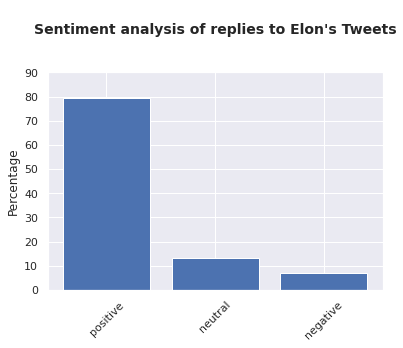

In [90]:
avg_score_toelon = [0,0,0]
for i in range(0,len(output_toelon)):
  avg_score_toelon = np.array(output_toelon[i]['scores'])+avg_score_toelon


plt.bar(x=candiadte_labels, height=100* avg_score_toelon/len(output_toelon))
plt.yticks(list(np.arange(0,100,10)))
plt.xticks(rotation = 45)
plt.title("\nSentiment analysis of replies to Elon's Tweets\n\n", fontsize = 14, fontweight = 'bold')
plt.ylabel("Percentage")
plt.show()

Done!
Honestly, more positive than I thought!

Ok, now, lets find out the most active followers from the replies. 

---



In [ ]:
Followers = list(df['username'])

In [92]:
#this function returns the first 5 accounts with the highest number of replies.
def findfollowers(orig_list):
  counts = {}
  for i in orig_list:
    if i in counts:
      counts[i] += 1
    else:
      counts[i] = 1
  follist = [k for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)[:5]]
  return follist


In [94]:
Active_Followers = Followers.copy()
Active_Followers = findfollowers(Active_Followers)
print("Active_Followers:\n")
pprint.pprint(Active_Followers)

Active_Followers:

['RobertJRussell7',
 'adanwachinemelu',
 'Yevgeni40658250',
 'DavidDesruisse3',
 'marisafromearth']


Pretty cool!
Now, lets summarize Elon's Tweets:

### 1.3. Account Summarization

For summarization,  we use a large language model (t5-large) using the sweet Huggingface API.


In [6]:
summarizer = pipeline('summarization', model='t5-large')

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [7]:
# Concatenate the text of all the tweets
alltext_elon = ""
for tweet in Tweetlist:
    alltext_elon += tweet

The model is designed for an input of 512 and due to a very large input size, it crashes if all tweets are used as input. Therefore, I am breaking it to a number of chunks with a length of 1024. The result would be a number of summaries, one for each chunk.
Then I again apply the summarization to the resulting contactenated text to get the final summary.  

In [11]:
import math
chunk_size = 1024
num_chunks = math.ceil(len(alltext_elon) / chunk_size)
chunks = [alltext_elon[i:i+chunk_size] for i in range(0, len(alltext_elon), chunk_size)]


In [15]:
# Summarize each chunk separately and concatenate the summaries
summary = ""
for chunk in chunks:
    chunk_summary = summarizer(chunk, max_length=150, min_length=20, do_sample=False)[0]["summary_text"]
    summary += chunk_summary.strip() + " "

In [16]:
summary

"@ShellenbergerMD Very entertaining @BillyM2k He studied the blade @JonathanTurley Wow@allgarbled @Teslaconomics Arabesque@ZubyMusic @jowualife @wholemarsblog @micsolana @drjbhattacharya Absolutely @ID_AA_Carmack @ggreenwald I think we should listen carefully to DWS, given that she is such an expert in ethics violations  she was forced to heir bidding as a collective NPC hivemind!?https://t.co/IYlRo3fd59 @CollinRugg I’m not his source, but, yeah, obviously asking journalists to reveal sources is not cool @micsolana Good thing LAT has “real” journalists @alx @ShellenbergerMD Great work! this is *actually* important for the health of our democracy . @TheBabylonBee @BillyM2k @WallStreetSilv Population collapse is the biggest threat to civilization@ZubyMusic We are running out of “conspiracies” that turned out to be true! @Westcoastbill V11 is a major step change improvement. iamharaldur: i also apologize to everyone named Alex in this . it was based on things i was told that were untrue o

Now, we have the summary of all 

In [17]:
account_summary = summarizer(summary, max_length=200, min_length=20, do_sample=False)[0]["summary_text"]


Token indices sequence length is longer than the specified maximum sequence length for this model (4057 > 512). Running this sequence through the model will result in indexing errors


In [23]:
! pip install pprint
import pprint
print("\33[1mThe summary of Elon's account is:\33[0m \n")
pprint.pprint(account_summary)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint
The summary of Elon's account is: 

('twitter is not financially healthy yet, but is trending to breakeven if we '
 'keep at it . ad revenue sharing with creators for ads that appear in their '
 'reply threads will sunset in a few months . twitter is a competitor to '
 'legacy media for news, so they are fundamentally conflicted .')


Interesting!

Now, let's have a look at our second Twitter Account.
## 2. Barack Obama
### 2.1. Scrapping Tweets

In [96]:
query_barack = '(from:barackobama) until:2023-03-11 since:2023-02-01'
limit = 1000
tweets_barack = []
for tweet in sntwitter.TwitterSearchScraper(query_barack).get_items():
  #print(vars(tweet))
  #break
  if len(tweets_barack)==limit:
    break
  else:
    tweets_barack.append([tweet.date, tweet.user.username, tweet.content])
  
  df_barack = pd.DataFrame(tweets_barack,columns = ['date','username','tweet'])


<ipython-input-96-31713060ef54>:10: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_barack.append([tweet.date, tweet.user.username, tweet.content])


### 2.2. Sentiment Analysis
#### 2.2.1. Barack's Tweets

In [145]:
Tweetlist = list(df_barack['tweet'])

candiadte_labels = ['positive','neutral','negative']
output_Barack = classifier(Tweetlist, candiadte_labels)


In [146]:
output_Barack[0:10]

[{'sequence': "For Women's History Month, I wanted to share the stories of Cary and Sharika—two women who've been building the Obama Presidential Center on the South Side of Chicago. I met them last year while visiting the site. Read their stories here: https://t.co/iSIl7dGFp8",
  'labels': ['positive', 'neutral', 'negative'],
  'scores': [0.7120043039321899, 0.19460663199424744, 0.0933891236782074]},
 {'sequence': '.@DemRedistrict hasn’t just been fighting for fair maps — they’ve been fighting to give people everywhere a fair shot. Our democracy is stronger today because of their hard work. https://t.co/ZudD9hrqTL',
  'labels': ['positive', 'neutral', 'negative'],
  'scores': [0.9741888046264648, 0.01328306458890438, 0.012528201565146446]},
 {'sequence': "This International Women's Day, read how @MichelleObama, @MelindaGates and Amal Clooney are working together to help end child marriage. I'm proud of the work @GirlsAlliance is doing to take on issues like this to create a better wor

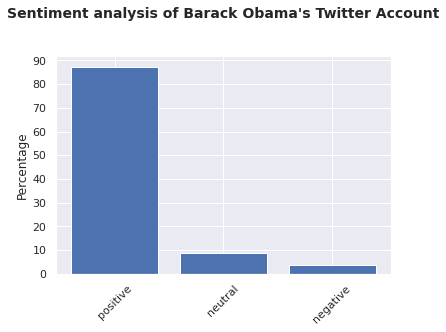

In [ ]:
avg_score_Barack = [0,0,0]
for i in range(0,len(output_Barack)):
  avg_score_Barack = np.array(output_Barack[i]['scores'])+avg_score_Barack


plt.bar(x=candiadte_labels, height=100* avg_score_Barack/len(output_Barack))
plt.yticks(list(np.arange(0,100,10)))
plt.xticks(rotation = 45)
plt.title("Sentiment analysis of Barack Obama's Twitter Account\n\n", fontsize = 14, fontweight = 'bold')
plt.ylabel("Percentage")
plt.show()

Well, not surprising!

#### 2.2.2. Tweet Replies

In [66]:
import pandas as pd
query = '(to:barackobama) until:2023-03-10 since:2023-02-01'
limit = 5000
tweets_tobarack = []
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  #print(vars(tweet))
  #break
  if len(tweets_tobarack)==limit:
    break
  else:
    tweets_tobarack.append([tweet.date, tweet.user.username, tweet.content])
  
  df = pd.DataFrame(tweets_tobarack,columns = ['date','username','tweet'])

<ipython-input-66-67adf2424cb2>:11: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_tobarack.append([tweet.date, tweet.user.username, tweet.content])


In [67]:
df

,date,username,tweet
0,2023-03-09 23:53:58+00:00,drunkback1991,@BarackObama drain the hope to voodoo late pun
1,2023-03-09 23:40:01+00:00,NichXII,@BarackObama @JoeBiden https://t.co/eKeP8YRrhp
2,2023-03-09 23:31:25+00:00,BragaDias5,@BarackObama @MichelleObama @melindagates @gir...
3,2023-03-09 23:26:04+00:00,Joe24926955,@BarackObama @MichelleObama @melindagates @gir...
4,2023-03-09 23:21:59+00:00,lappoint9558248,@BarackObama \nSakib Khan = Red Body color = M...
...,...,...,...
4995,2023-02-21 15:36:25+00:00,MichaelGOAT23,@BarackObama @ObamaFoundation LIKE &amp; SUBSC...
4996,2023-02-21 15:36:18+00:00,SleeperAgent05,@BarackObama @ObamaFoundation Thank you Obama ...
4997,2023-02-21 15:32:21+00:00,jcohee2,@BarackObama @POTUS @FLOTUS @GavinNewsom all o...
4998,2023-02-21 15:24:03+00:00,jcohee2,@BarackObama @POTUS This is your fault Obama h...


In [68]:
Tweetlist = list(df['tweet'])

candiadte_labels = ['positive','neutral','negative']
output_tobarack = classifier(Tweetlist, candiadte_labels)


Here, we can we how positive or negative the tweet replies are: 

In [147]:
output_tobarack[0:10]

[{'sequence': '@BarackObama drain the hope to voodoo late pun',
  'labels': ['negative', 'positive', 'neutral'],
  'scores': [0.9076935648918152, 0.04854387789964676, 0.043762531131505966]},
 {'sequence': '@BarackObama @JoeBiden https://t.co/eKeP8YRrhp',
  'labels': ['positive', 'negative', 'neutral'],
  'scores': [0.6981607675552368, 0.19644376635551453, 0.10539539903402328]},
 {'sequence': '@BarackObama @MichelleObama @melindagates @girlsalliance good evening sir, my name is Francisco José Braga, I am only Mozambican from the province of Zambézia, I only graduated in industrial electricity and I am unemployed I know I am wrong to ask this I really want to have my own business because employment in my country is difficult',
  'labels': ['negative', 'positive', 'neutral'],
  'scores': [0.8023900389671326, 0.11958688497543335, 0.0780230164527893]},
 {'sequence': '@BarackObama @MichelleObama @melindagates @girlsalliance 🇺🇸😎 https://t.co/TnfYkG6SO7',
  'labels': ['positive', 'neutral', 'n

Now, lets have a look at the sentiment analysis of the overal audience.

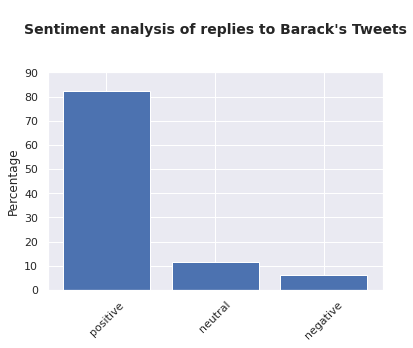

In [76]:
avg_score_tobarack = [0,0,0]
for i in range(0,len(output_tobarack)):
  avg_score_tobarack = np.array(output_tobarack[i]['scores'])+avg_score_tobarack


plt.bar(x=candiadte_labels, height=100* avg_score_tobarack/len(output_tobarack))
plt.yticks(list(np.arange(0,100,10)))
plt.xticks(rotation = 45)
plt.title("\nSentiment analysis of replies to Barack's Tweets\n\n", fontsize = 14, fontweight = 'bold')
plt.ylabel("Percentage")
plt.show()

Done!

Ok, now, lets find out the most active followers from the replies. 

In [ ]:
Followers = list(df['username'])

In [72]:
def reduce_to_duplicates(orig_list):
  counts = {}
  for i in orig_list:
    if i in counts:
      counts[i] += 1
    else:
      counts[i] = 1
  duplist = [k for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)[:5]]
  return duplist


In [75]:
Active_Followers = Followers.copy()
Active_Followers = reduce_to_duplicates(Active_Followers)
print("Barack's Active_Followers:\n")
pprint.pprint(Active_Followers)

Barack's Active_Followers:

['lorinczlevente9', 'OzielNatalie', 'FreshUgg', 'r_couch2', 'lappoint9558248']


And now, it's time for summarization:

### 2.3. Account Summarization

In [97]:
Tweetlist = list(df_barack['tweet'])
# Concatenate the text of all the tweets
alltext_Barack = ""
for tweet in Tweetlist:
    alltext_Barack += tweet

In [98]:
alltext_Barack

"For Women's History Month, I wanted to share the stories of Cary and Sharika—two women who've been building the Obama Presidential Center on the South Side of Chicago. I met them last year while visiting the site. Read their stories here: https://t.co/iSIl7dGFp8.@DemRedistrict hasn’t just been fighting for fair maps — they’ve been fighting to give people everywhere a fair shot. Our democracy is stronger today because of their hard work. https://t.co/ZudD9hrqTLThis International Women's Day, read how @MichelleObama, @MelindaGates and Amal Clooney are working together to help end child marriage. I'm proud of the work @GirlsAlliance is doing to take on issues like this to create a better world for girls everywhere.https://t.co/m49a4abtjkJudy Heumann dedicated her life to the fight for civil rights—starting as a young organizer at Camp Jened and later helping lead the disability rights movement. Michelle and I were fortunate to work with Judy over the years, and are thinking of her family

In [ ]:
account_summary = summarizer(alltext_Barack, max_length=200, min_length=20)[0]["summary_text"]
account_summary

"for women's history month, i wanted to share the stories of cary and Sharika . i'm proud of the work @GirlsAlliance is doing to end child marriage . http://t.co/m49a4abtjkEdith childs understands the power of a single voice ."

In [ ]:
print("\33[1mThe summary of Barack's account is:\33[0m \n")
pprint(account_summary)

The summary of Barack's account is: 

("for women's history month, i wanted to share the stories of cary and Sharika "
 ". i'm proud of the work @GirlsAlliance is doing to end child marriage . "
 'http://t.co/m49a4abtjkEdith childs understands the power of a single voice .')


No wonder the average content was close to 90% positive!

Now, let's summarize in two paragraphs:

In [99]:
summary1 = summarizer(alltext_Barack, max_length=400, min_length=50)[0]["summary_text"]

# Generate a second summary that complements the first
num_sentences = summary1.count('. ') + 1  # Count the number of sentences in summary1
sentences = alltext_Barack.split('. ')  # Split the text at sentence boundaries
midpoint = num_sentences * len(sentences) // (2 * num_sentences)  # Find the midpoint based on sentence count

text2 = ' '.join(sentences[midpoint:])
summary2 = summarizer(text2, max_length=400, min_length=50)[0]["summary_text"]

# Assign the two summaries to different paragraphs
summary_paragraph1 = summary1
summary_paragraph2 = summary2

In [125]:
pprint.pprint(summary_paragraph1)
print("\n")
pprint.pprint(summary_paragraph2)

("for women's history month, i wanted to share the stories of cary and Sharika "
 ". i'm proud of the work @GirlsAlliance is doing to help end child marriage . "
 'http://t.co/m49a4abtjkEdith childs understands the power of a single voice .')


('the scale of devastation after the earthquakes in Türkiye and Syria is '
 'almost unimaginable Michelle and i are thinking of the thousands of people '
 'who have been affected . 105 young people from across africa, Asia-Pacific, '
 'and Europe will be joining the @ObamaFoundation Leaders program .')


## 3. **Cathie Wood**

Side note: she is founder, CEO and CIO of ARKinvest. 

### 3.1. Scrapping Tweets




In [127]:
query_cathi = '(from:cathiedwood) until:2023-03-11 since:2023-02-01'
limit = 1000
tweets_cathi = []
for tweet in sntwitter.TwitterSearchScraper(query_cathi).get_items():
  #print(vars(tweet))
  #break
  if len(tweets_cathi)==limit:
    break
  else:
    tweets_cathi.append([tweet.date, tweet.user.username, tweet.content])
  
  df_cathi = pd.DataFrame(tweets_cathi,columns = ['date','username','tweet'])


<ipython-input-127-052ad0e7f6c7>:10: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_cathi.append([tweet.date, tweet.user.username, tweet.content])


### 3.2. Sentiment Analysis
#### 3.2.1. Cathie's Tweets

In [ ]:

Tweetlist = list(df_cathi['tweet'])
candiadte_labels = ['positive','neutral','negative']
output_cathi = classifier(Tweetlist, candiadte_labels)


In [148]:
output_cathi[0:10]

[{'sequence': 'As Art Laffer postulates in his latest book, “Taxes Have Consequences”. Given Biden’s latest budget proposals, the great migration to low or no tax states like FL and TN and, in my view, to countries hungry for innovation in Asia and elsewhere is likely to accelerate.',
  'labels': ['negative', 'neutral', 'positive'],
  'scores': [0.8147342801094055, 0.11017666757106781, 0.07508909702301025]},
 {'sequence': 'Provocative. During the last few years, I have expressed my frustration with Google search, deeming it primitive AI, notwithstanding Alphabet’s DeepMind expertise. OpenAI/Microsoft’s ChatGPT is the “iPhone moment” of this decade, changing everything. Disruptive innovation!',
  'labels': ['positive', 'negative', 'neutral'],
  'scores': [0.8569517135620117, 0.10273782908916473, 0.04031042382121086]},
 {'sequence': 'Important perspective.',
  'labels': ['positive', 'neutral', 'negative'],
  'scores': [0.8098917007446289, 0.10573817789554596, 0.08437015116214752]},
 {'se

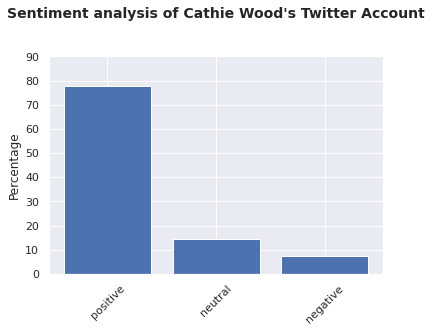

In [ ]:
avg_score_cathi = [0,0,0]
for i in range(0,len(output_cathi)):
  avg_score_cathi = np.array(output_cathi[i]['scores'])+avg_score_cathi


plt.bar(x=candiadte_labels, height=100*avg_score_cathi/len(output_cathi))
plt.yticks(list(np.arange(0,100,10)))
plt.xticks(rotation = 45)
plt.title("Sentiment analysis of Cathie Wood's Twitter Account\n\n", fontsize = 14, fontweight = 'bold')
plt.ylabel("Percentage")
plt.show()

Close to Elon.

#### 3.2.2. Tweet Replies

In [77]:
import pandas as pd
query = '(to:cathiedwood) until:2023-03-10 since:2023-02-01'
limit = 5000
tweets_tocathi = []
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  #print(vars(tweet))
  #break
  if len(tweets_tocathi)==limit:
    break
  else:
    tweets_tocathi.append([tweet.date, tweet.user.username, tweet.content])
  
  df = pd.DataFrame(tweets_tocathi,columns = ['date','username','tweet'])

<ipython-input-77-39e66b429c0d>:11: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_tocathi.append([tweet.date, tweet.user.username, tweet.content])


In [78]:
df

,date,username,tweet
0,2023-03-09 23:53:53+00:00,MattF888,@CathieDWood Wheres the money coming from afte...
1,2023-03-09 22:31:31+00:00,dkawnik,"@CathieDWood Is there a ""Steve Jobs"" to see it..."
2,2023-03-09 22:30:49+00:00,shuhebpontanath,"@CathieDWood ‘s #ARKK \nhas bought 69,329 more..."
3,2023-03-09 22:23:14+00:00,N_J_Calla23,@CathieDWood It's not even AI. It's censored a...
4,2023-03-09 22:16:40+00:00,N_J_Calla23,@CathieDWood @ARKInvest @downingARK @summerlin...
...,...,...,...
2471,2023-02-01 03:25:48+00:00,anas7acia,@CathieDWood @ARKInvest 200? Wow 🤩
2472,2023-02-01 03:25:40+00:00,SilentAlert1,"@CathieDWood @ARKInvest Should add @Hyliion, l..."
2473,2023-02-01 03:25:22+00:00,now_weblife,@CathieDWood @ARKInvest wow
2474,2023-02-01 03:25:09+00:00,CathieDWood,"With many thanks to our Chief Futurist, @winto..."


In [79]:
Tweetlist = list(df['tweet'])

candiadte_labels = ['positive','neutral','negative']
output_tocathi = classifier(Tweetlist, candiadte_labels)


Here, we can we how positive or negative the tweet replies are: 

In [149]:
output_tocathi[0:10]

[{'sequence': '@CathieDWood Wheres the money coming from after millions come to grips with reality on their fresh and juicy new 6％ renewal mortgage. The " Green transition hype" will  fizzle to dust in the wind. Govt policy makes ZERO sense. Pipe Dream.',
  'labels': ['negative', 'positive', 'neutral'],
  'scores': [0.9570214748382568, 0.02485339157283306, 0.018125135451555252]},
 {'sequence': '@CathieDWood Is there a "Steve Jobs" to see it through to fruition though at Microsoft?',
  'labels': ['negative', 'positive', 'neutral'],
  'scores': [0.6504982113838196, 0.19439375400543213, 0.15510797500610352]},
 {'sequence': '@CathieDWood ‘s #ARKK \nhas bought 69,329 more shares of $TSLA. \n#TSLA #bargain #elon_musk',
  'labels': ['positive', 'negative', 'neutral'],
  'scores': [0.5580429434776306, 0.2851247489452362, 0.1568322628736496]},
 {'sequence': "@CathieDWood It's not even AI. It's censored algorithmic propaganda For the marxist takeover of the planet.",
  'labels': ['negative', 'ne

Now, lets have a look at the sentiment analysis of the overal audience.

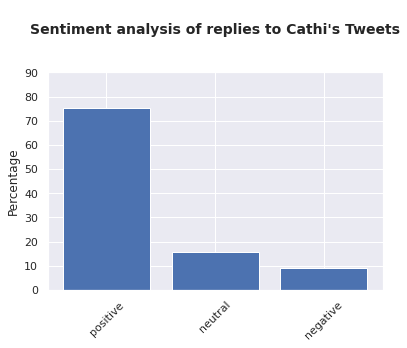

In [82]:
avg_score_tocathi = [0,0,0]
for i in range(0,len(output_tocathi)):
  avg_score_tocathi = np.array(output_tocathi[i]['scores'])+avg_score_tocathi


plt.bar(x=candiadte_labels, height=100* avg_score_tocathi/len(output_tocathi))
plt.yticks(list(np.arange(0,100,10)))
plt.xticks(rotation = 45)
plt.title("\nSentiment analysis of replies to Cathi's Tweets\n\n", fontsize = 14, fontweight = 'bold')
plt.ylabel("Percentage")
plt.show()

Done!

Ok, now, lets find out the most active followers from the replies. 

In [ ]:
Followers = list(df['username'])

In [84]:
def reduce_to_duplicates(orig_list):
  counts = {}
  for i in orig_list:
    if i in counts:
      counts[i] += 1
    else:
      counts[i] = 1
  duplist = [k for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)[:5]]
  return duplist


In [85]:
Active_Followers = Followers.copy()
Active_Followers = reduce_to_duplicates(Active_Followers)
print("Cathi's Active_Followers:\n")
pprint.pprint(Active_Followers)

Cathi's Active_Followers:

['jeno_long', 'MKucala', 'ChaseAli', 'ekfpromo', 'DeGeneralDimes']


And lastly, account summarization!

### 3.3. Account Summarization

In [138]:
# Concatenate the text of all the tweets
alltext_Cathi = ""
for tweet in Tweetlist:
    alltext_Cathi += tweet
alltext_Cathi

'As Art Laffer postulates in his latest book, “Taxes Have Consequences”. Given Biden’s latest budget proposals, the great migration to low or no tax states like FL and TN and, in my view, to countries hungry for innovation in Asia and elsewhere is likely to accelerate.Provocative. During the last few years, I have expressed my frustration with Google search, deeming it primitive AI, notwithstanding Alphabet’s DeepMind expertise. OpenAI/Microsoft’s ChatGPT is the “iPhone moment” of this decade, changing everything. Disruptive innovation!Important perspective.On @CNBC this week, @SaraEisen asked if #Tesla is cutting prices in response to competition. After investor day, @skorusARK illustrated that Tesla is passing along drivetrain cost declines that will cut the price of the Model 3 in half to $25,000, undercutting competition!Welcome to @ARKInvest, Daniel! We are delighted that you will be working with @TashaARK and @skorusARK to  research autonomous mobility, the biggest technologicall

In [ ]:
summarizer = pipeline('summarization', model='t5-large')

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
account_summary = summarizer(alltext_Cathi, max_length=200, min_length=20)[0]["summary_text"]

Token indices sequence length is longer than the specified maximum sequence length for this model (979 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


"ARK's Big Ideas 2023 details ARK’s forecasts for disruptive innovation platforms . the market value of disruption platforms could scale 40% at an annual rate by 2030 . ark's research shows that e-commerce is poised to become a trillion-dollar industry by 2025 ."

In [ ]:
! pip install pprint
from pprint import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


In [ ]:
print("\33[1mThe summary of Taylor's account is:\33[0m \n")
pprint(account_summary)

The summary of Taylor's account is: 

("ARK's Big Ideas 2023 details ARK’s forecasts for disruptive innovation "
 'platforms . the market value of disruption platforms could scale 40% at an '
 "annual rate by 2030 . ark's research shows that e-commerce is poised to "
 'become a trillion-dollar industry by 2025 .')


Now, let's summarize in two paragraphs:

In [139]:
summary1_cathi = summarizer(alltext_Cathi, max_length=400, min_length=50)[0]["summary_text"]

# Generate a second summary that complements the first
num_sentences = summary1_cathi.count('. ') + 1  # Count the number of sentences in summary1
sentences = alltext_Cathi.split('. ')  # Split the text at sentence boundaries
midpoint = num_sentences * len(sentences) // (2 * num_sentences)  # Find the midpoint based on sentence count

text2 = ' '.join(sentences[midpoint:])
summary2_cathi = summarizer(text2, max_length=400, min_length=50)[0]["summary_text"]

# Assign the two summaries to different paragraphs
summary_paragraph1_cathi = summary1_cathi
summary_paragraph2_cathi = summary2_cathi

In [140]:
print("\33[1mThe summary of Taylor's account is:\33[0m \n")
pprint.pprint(summary_paragraph1_cathi)
print("\n")
pprint.pprint(summary_paragraph2_cathi)

The summary of Taylor's account is: 

("ARK's Big Ideas 2023 details ARK’s forecasts for disruptive innovation "
 'platforms . the market value of disruption platforms could scale 40% at an '
 "annual rate by 2030 . ark's research shows that e-commerce is poised to "
 'become a trillion-dollar industry by 2025 .')


('ARKInvest published the seventh edition of Big Ideas 2023 . the market value '
 'of disruptive innovation platforms could scale 40% at an annual rate during '
 'this cycle, from $13 trillion today to $200 trillion by 2030 . ARK’s '
 'research shows that the future of investing is investing in the future .')


All done! There is of course room for improvement, especially in summarization when it comes to more than one paragraph.

As a next step, we can also try streaming the results using a REST API.
There are also lots of other analysis we can do applying these methods. For instance, if we define the categories as Elon's companies and investigate the amount of tweets about them using sentiment analysis, there might (or might not) be a correlation between this pattern and the company's stocks.
And lots of other fun things to try!

If you have any qestions or wanted to discuss further, please contact me via: nheydari@uwaterloo.ca